# Parks and Recreation Data Cleaning and Analysis

Load raw data file `City_Facilities_-_Recreation_and_Parks_Jurisdiction_or_Leased_20251109.csv` 
from the raw data folder. Use necessary libraries to for data cleaning, analysis, and visualization.

The raw data for this was downloaded from [DataSF | Open Data Portal - City Facilities - Recreation and Parks Jurisdiction or Leased](https://data.sfgov.org/City-Infrastructure/City-Facilities-Recreation-and-Parks-Jurisdiction-/2mqz-ak5w/about_data) 

In [28]:
# import necessary dependencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from census import Census
from us import states
import os
from pathlib import Path
from IPython.display import display
import seaborn as sns
import re
import zipfile
from shapely.geometry import Point


In [29]:
# use robust path handling to locate the data file
def find_repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start] + list(start.parents):
        if (p / 'requirements.txt').exists() or (p / '.git').exists():
            return p
    return start

repo_root = find_repo_root()
data_file = repo_root / 'data' / 'raw' / 'City_Facilities_-_Recreation_and_Parks_Jurisdiction_or_Leased_20251109.csv'

if not data_file.exists():
    raise FileNotFoundError(f"Data file not found at {data_file}. Check the file name and data/raw folder.")

# load the data from the data/raw folder
parks_and_rec_df = pd.read_csv(data_file, low_memory=False)

### Parks and Recreation City Facilities EDA

#### Initial Look at the Raw Data

In [30]:
# see the first 5 rows of the data
display(parks_and_rec_df.head())

,facility_id,common_name,address,city,zip_code,block_lot,owned_leased,dept_id_for_jurisdiction,jurisdiction,gross_sq_ft,longitude,latitude,supervisor_district,city_tenants
0,3520,240 6th St,240 6th St,San Francisco,94103,3731004,Own,49,Recreation And Parks,NaN,-122.406798,37.778960,6.0,NaN
1,3342,500 Pine Rooftop Park,500 Pine St,San Francisco,94108,0258042,Own,49,Recreation And Parks,NaN,-122.404581,37.791879,3.0,NaN
2,3339,900 Innes Ave,900 Innes Ave,San Francisco,94124,4629A010,Own,49,Recreation And Parks,NaN,-122.375781,37.732187,10.0,NaN
3,10,Adam Rogers Park Bathrooms,45 George Ct,San Francisco,94124,4700055,Own,49,Recreation And Parks,NaN,-122.383705,37.730880,10.0,NaN
4,108,Alamo Square Bathrooms,1081 Fulton St,San Francisco,94117,0799001,Own,49,Recreation And Parks,500,-122.434338,37.776070,5.0,NaN


In [31]:
# seeing the number of rows and columns in the data
print("The number of (rows, columns) in this DataFrame is", parks_and_rec_df.shape)

# seeing the column names in the data
print("The columns in this DataFrame are:\n", parks_and_rec_df.columns.tolist())

The number of (rows, columns) in this DataFrame is (574, 14)
The columns in this DataFrame are:
 ['facility_id', 'common_name', 'address', 'city', 'zip_code', 'block_lot', 'owned_leased', 'dept_id_for_jurisdiction', 'jurisdiction', 'gross_sq_ft', 'longitude', 'latitude', 'supervisor_district', 'city_tenants']


In [32]:
# getting summary information about the data including # null, data types etc.
parks_and_rec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   facility_id               574 non-null    int64  
 1   common_name               574 non-null    object 
 2   address                   574 non-null    object 
 3   city                      574 non-null    object 
 4   zip_code                  574 non-null    int64  
 5   block_lot                 572 non-null    object 
 6   owned_leased              574 non-null    object 
 7   dept_id_for_jurisdiction  574 non-null    int64  
 8   jurisdiction              574 non-null    object 
 9   gross_sq_ft               235 non-null    object 
 10  longitude                 574 non-null    float64
 11  latitude                  574 non-null    float64
 12  supervisor_district       458 non-null    float64
 13  city_tenants              4 non-null      object 
dtypes: float64

In [33]:
# getting summary statistics for numerical columns
parks_and_rec_df.describe()

,facility_id,zip_code,dept_id_for_jurisdiction,longitude,latitude,supervisor_district
count,574.000000,574.000000,574.000000,574.000000,574.000000,458.000000
mean,1198.630662,94353.594077,48.721254,-121.948965,37.783527,5.515284
std,920.896395,476.807582,3.330383,1.032795,0.053428,3.012154
min,1.000000,94044.000000,9.000000,-122.510206,37.624935,1.000000
25%,456.500000,94117.000000,49.000000,-122.477980,37.747821,3.000000
50%,988.000000,94118.000000,49.000000,-122.447323,37.769459,7.000000
75%,1632.750000,94133.000000,49.000000,-122.405449,37.795794,7.000000
max,3520.000000,95321.000000,49.000000,-119.851863,37.883704,11.000000


Based on this initial glance of the data, this are my main insights and next steps for data cleaning:
- Some of the datatypes are mislabeled. For example, `facility_id`, `zip_code`, `dept_id_for_jurisdiction`, and `supervisor_district` should be an object. On the other hand, `gross_sq_ft` should be an numeric (like float) data point.
- Less than half of the columns have non-missing data for `gross_sq_ft` 235/574 - to be exact, so we need to figure out how we can handle this missing data as this value is important for our analysis. Looking at the Open Data Portal page for this dataset, they have noted that the original source of this data is FRRM and that this is "incomplete data, updating as values are determined." This value is important for us because we are looking at the per-capita availability of parks and recreation facilities at the tract level.
- This dataset maps Parks and Recreation facilities to the `block_lot` level when we are interested in the Census Tract level. We need to figure out how to convert the data to that level.

#### Data Cleaning

As listed above, I started off converting mislabeled datatypes to their respective correct types.

In [34]:
# fixing mislabeled datatypes
parks_and_rec_df['facility_id'] = parks_and_rec_df['facility_id'].astype(str)
parks_and_rec_df['zip_code'] = parks_and_rec_df['zip_code'].astype(str)
parks_and_rec_df['dept_id_for_jurisdiction'] = parks_and_rec_df['dept_id_for_jurisdiction'].astype(str)
parks_and_rec_df['supervisor_district'] = parks_and_rec_df['supervisor_district'].astype(str)

# holding off on converting gross_sq_ft to numeric due to many missing values --> want to explore more before converting
#parks_and_rec_df['gross_sq_ft'] = pd.to_numeric(parks_and_rec_df['gross_sq_ft'], errors='coerce')  

# checking the datatypes after fixing them
parks_and_rec_df.dtypes

facility_id                  object
common_name                  object
address                      object
city                         object
zip_code                     object
block_lot                    object
owned_leased                 object
dept_id_for_jurisdiction     object
jurisdiction                 object
gross_sq_ft                  object
longitude                   float64
latitude                    float64
supervisor_district          object
city_tenants                 object
dtype: object

Now, I'll look deeper into `city` and `zip_code` columns to identify if there are any redundant columns. In this case, there aren't any. There are a few parks and zip codes in neighboring cities next to SF like Pacifica (which makes sense) parks can extend SF boundary. However, this also doesn't make sense because Groveland (for example) is not in SF or neighboring at all. I'll uncover something about this below when I look further at the missing data in the `gross_sq_ft` column in a bit.

In [35]:
# understanding the unique values in 'city' column
display(parks_and_rec_df["city"].value_counts())

# understand the unique values in 'zip_code' column
display(parks_and_rec_df["zip_code"].value_counts())

city
San Francisco    460
Groveland        112
Pacifica           2
Name: count, dtype: int64

zip_code
94117    158
95321    112
94132     50
94121     25
94134     23
94110     20
94112     18
94116     18
94123     17
94124     15
94122     14
94118     13
94108     12
94115     11
94133     10
94102      9
94131      9
94109      8
94114      7
94107      7
94127      6
94103      5
94111      4
94044      2
94105      1
Name: count, dtype: int64

Moving onto looking at the `gross_sq_ft` column to conver the existing values to numeric data types and make an educated decision to handle the missing data.

In [36]:
# exploring the gross_sq_ft column to see what the values look like
display(parks_and_rec_df['gross_sq_ft'].value_counts())
display(parks_and_rec_df['gross_sq_ft'].describe())
display(parks_and_rec_df['gross_sq_ft'].head(10))

gross_sq_ft
1,200     15
500        8
2,000      5
1,500      4
432        3
          ..
8,001      1
576        1
19,446     1
2,187      1
2,135      1
Name: count, Length: 185, dtype: int64

count       235
unique      185
top       1,200
freq         15
Name: gross_sq_ft, dtype: object

0      NaN
1      NaN
2      NaN
3      NaN
4      500
5    2,505
6      NaN
7      432
8    1,200
9    2,196
Name: gross_sq_ft, dtype: object

What I notice about the `gross_sq_ft` column is that there are commas in the numbers (ex. 1,200), so I need to take care for that when converting to numeric data types. Also, out of the 235 non-null values, 185 are unique, which suggests that some of the values are estimates of the gross sq. ft. of these facilities. This could be useful for handling the missing data.

I'll convert the existing non-null values of `gross_sq_ft` column correctly below:

In [37]:
# convert gross_sq_ft to numeric safely, keeping original values for reference
parks_and_rec_df['gross_sq_ft_raw'] = parks_and_rec_df['gross_sq_ft'].astype(object)

# remove commas and any non-digit/decimal/minus characters, convert empty -> NaN
parks_and_rec_df['gross_sq_ft_clean'] = (
    parks_and_rec_df['gross_sq_ft_raw']
    .astype(str)
    .str.replace(r'[^\d\.\-]', '', regex=True)   # strips commas and non-numeric characters
    .replace('', np.nan)
)

# final numeric conversion (coerce invalid -> NaN)
parks_and_rec_df['gross_sq_ft'] = pd.to_numeric(parks_and_rec_df['gross_sq_ft_clean'], errors='coerce')
parks_and_rec_df.drop(columns=['gross_sq_ft_clean'], inplace=True)  # drop clean column to avoid confusion

# checking that there are 235 non-null values in gross_sq_ft after conversion
print("numeric non-null:", parks_and_rec_df['gross_sq_ft'].notna().sum())

numeric non-null: 235


In [38]:
# looking at the rows where gross_sq_ft is still NaN after conversion to see if there are any patterns
display(parks_and_rec_df[parks_and_rec_df['gross_sq_ft'].isna()].groupby('jurisdiction').agg({'facility_id':'count'}).sort_values(by='facility_id', ascending=False))
display(parks_and_rec_df[parks_and_rec_df['gross_sq_ft'].isna()].groupby('city').agg({'facility_id':'count'}).sort_values(by='facility_id', ascending=False))
display(parks_and_rec_df[parks_and_rec_df['gross_sq_ft'].isna()].groupby('supervisor_district').agg({'facility_id':'count'}).sort_values(by='facility_id', ascending=False))
display(parks_and_rec_df[parks_and_rec_df['gross_sq_ft'].isna()].groupby('address').agg({'facility_id':'count'}).sort_values(by='facility_id', ascending=False))

,facility_id
jurisdiction,
Recreation And Parks,335
Non-City,4


,facility_id
city,
San Francisco,225
Groveland,112
Pacifica,2


,facility_id
supervisor_district,
nan,114
7.0,80
4.0,30
1.0,27
10.0,16
3.0,14
9.0,14
5.0,13
2.0,10


,facility_id
address,
32560 Mather Rd,110
1 Zoo Rd,31
100 Martin Luther King Dr,20
100 John F Kennedy Dr,7
1199 09th Ave,4
...,...
2301 San Jose Ave,1
2100 Martin Luther King Jr Dr,1
21 CHAIN OF LAKES DR,1


In [39]:
# looking deeper at the "1 Zoo Rd" address
parks_and_rec_df[parks_and_rec_df['address'] == "1 Zoo Rd"].head(5)

,facility_id,common_name,address,city,zip_code,block_lot,owned_leased,dept_id_for_jurisdiction,jurisdiction,gross_sq_ft,longitude,latitude,supervisor_district,city_tenants,gross_sq_ft_raw
543,3126,ZOO - ANIMAL HOSPITAL*,1 Zoo Rd,San Francisco,94132,7281002,Own,49,Recreation And Parks,NaN,-122.503913,37.731741,7.0,NaN,NaN
544,3127,ZOO - AVIARY*,1 Zoo Rd,San Francisco,94132,7281002,Own,49,Recreation And Parks,NaN,-122.503223,37.732559,7.0,NaN,NaN
545,3128,ZOO - BEAR DENS*,1 Zoo Rd,San Francisco,94132,7281002,Own,49,Recreation And Parks,NaN,-122.501909,37.731501,7.0,NaN,NaN
546,3129,ZOO - CAPYBARA SHELTER*,1 Zoo Rd,San Francisco,94132,7281002,Own,49,Recreation And Parks,NaN,-122.501543,37.731567,7.0,NaN,NaN
547,3130,ZOO - CAROUSEL,1 Zoo Rd,San Francisco,94132,7281002,Own,49,Recreation And Parks,NaN,-122.503791,37.733596,7.0,NaN,NaN


In [40]:
# taking a deeper look at 100 Martin Luther King Dr	
parks_and_rec_df[parks_and_rec_df['address'] == "100 Martin Luther King Dr"]["common_name"]

20                               Auto Shop
174    Corporate Yard Maintenance Facility
175                 Corporate Yard Storage
176                  Corp Yard Gas Station
178             CORP. YARD P.PATROL/SHOPS*
179                  CORP YARD / Warehouse
187                Double Dutch Head House
195                Electrical & Iron Shops
197            Emergency Equipment Storage
221                        GGP Greenhouses
334                           Masonry Shop
383                      Nursery Bathrooms
384                    Nursery Cold Frames
385                     NURSERY-COLD HOUSE
386                      NURSERY-HOT HOUSE
387                  Nursery Potting Sheds
388                   Nursery Shade Houses
389                 Nursery Storage Sheds*
390                 Paint & Carpentry Shop
407                          Plumbing Shop
436                           Roofing Shop
470     Stationary Engineers & Electric Rm
490               Struct Maint Storage Lot
491        

After exploring how the `gross_sq_ft` column relates to some of the other variables above, here are some things that stand out to me:
- All the Groveland data has missing gross_sq_feet. This is important because Groveland is not neighboring SF (at all). The most common address in this category 32560 Mather Rd is a part of Stanislaus National Park/Yosemite National Park, which I found out by looking at this location in Google Maps. This isn't an SF facility, but is including in the dataset because a significant portion of the SFPUC's water system facilities are located in Tuolumne County. These values can be dropped as they don't affect our research in terms of parks in SF.
- The next common address 1 Zoo Rd, corresponds to the SF Zoo and specific attraction in the zoo like Aviary or Bear Dens. The reason the gross_sq_ft is not updated for each of these values is likely because the area of the inner attractions keep changing. The census tract that the SF Zoo is in 06075060400  mainly includes just the zoo and Lake Merced Park, so basically the whole census tract can be classified under "Parks and Recreation" area.
- The 100 Martin Luther King Dr location includes 06075980300 Census Tract, which corresponds to Golden Gate Park. This tract just includes Golden Gate Park, which includes the park, California Academy of Sciences, SF Botanical Garden, and other smaller shops/amenities. Similar to the zoo, I'll be mindful of this tract and qualify basically the whole tract area as "Parks and Recreation."

Now let me apply the data cleaning above first before further exploring the missing `gross_sq_ft`.

In [41]:
# this seems to be a golf course in  Pacifica, so I can leave it out for now since it's not in SF
display(parks_and_rec_df[parks_and_rec_df['city'] == "Pacifica"])

,facility_id,common_name,address,city,zip_code,block_lot,owned_leased,dept_id_for_jurisdiction,jurisdiction,gross_sq_ft,longitude,latitude,supervisor_district,city_tenants,gross_sq_ft_raw
458,3162,SHARP PARK CLUBHOUSE & REST.,2600 Francisco Blvd,Pacifica,94044,016392120,Own,49,Recreation And Parks,NaN,-122.488816,37.624935,nan,NaN,NaN
459,3163,SHARP PARK GARDENERS SHED,2600 Francisco Blvd,Pacifica,94044,016392120,Own,49,Recreation And Parks,NaN,-122.488464,37.625311,nan,NaN,NaN


In [42]:
# this seems to be a golf course in  Pacifica, so I can leave it out for now since it's not in SF
display(parks_and_rec_df[parks_and_rec_df['city'] == "Pacifica"])

,facility_id,common_name,address,city,zip_code,block_lot,owned_leased,dept_id_for_jurisdiction,jurisdiction,gross_sq_ft,longitude,latitude,supervisor_district,city_tenants,gross_sq_ft_raw
458,3162,SHARP PARK CLUBHOUSE & REST.,2600 Francisco Blvd,Pacifica,94044,016392120,Own,49,Recreation And Parks,NaN,-122.488816,37.624935,nan,NaN,NaN
459,3163,SHARP PARK GARDENERS SHED,2600 Francisco Blvd,Pacifica,94044,016392120,Own,49,Recreation And Parks,NaN,-122.488464,37.625311,nan,NaN,NaN


In [43]:
# remove rows with Pacifica and Groveland as city from the DataFrame, maintaining only San Francisco entries
parks_and_rec_df = parks_and_rec_df[parks_and_rec_df['city'] == "San Francisco"]
parks_and_rec_df.shape

(460, 15)

In [44]:
# remove rows with the address "1 Zoo Rd" since it's the SF Zoo and not a park
parks_and_rec_df = parks_and_rec_df[parks_and_rec_df['address'] != "1 Zoo Rd"]

# remove rows with address "100 Martin Luther King Dr" since it's the Golden Gate Park
parks_and_rec_df = parks_and_rec_df[parks_and_rec_df['address'] != "100 Martin Luther King Dr"]

# remove the 100 John F Kennedy Dr address since it's also part of Golden Gate Park (Conservatory of Flowers)
parks_and_rec_df = parks_and_rec_df[parks_and_rec_df['address'] != "100 John F Kennedy Dr"]

# remove 225 Stockton St because it's Union Square Park stage, concessions, etc. which changes frequently
parks_and_rec_df = parks_and_rec_df[parks_and_rec_df['address'] != "225 Stockton St"]

# remove 1199 09th Ave missing values because those are in Golden Gate Park as well (Arboretum mainly)
parks_and_rec_df = parks_and_rec_df[parks_and_rec_df['address'] != "1199 09th Ave"]

# remove 799 Moscow St missing values since it's very tiny parts of Crocker Amazon Park (which is already accounted for)
parks_and_rec_df = parks_and_rec_df[parks_and_rec_df['address'] != "799 Moscow St"]


parks_and_rec_df.shape

(364, 15)

In [45]:
# now explore the missing gross_sq_ft addresses again
display(parks_and_rec_df[parks_and_rec_df['gross_sq_ft'].isna()].groupby('address').agg({'facility_id':'count'}).sort_values(by='facility_id', ascending=False))

,facility_id
address,
University St & Woolsey St,3
991 Lake Merced Blvd,3
Bercut Access Rd & Chain of Lakes Dr,3
Nancy Pelosi Dr & Martin Luther King Jr Dr,3
51 Havelock St,2
...,...
2301 San Jose Ave,1
2100 Martin Luther King Jr Dr,1
21 CHAIN OF LAKES DR,1


In [46]:
# interpolate missing gross_sq_ft using medians for maintenance / shed / bathroom (and restroom) categories
# note for this section I used AI (gpt-5-mini) to help robustly identify and fill the categories, but I made sure to understand the code and tweak it as needed

# normalize common_name for robust matching
common = parks_and_rec_df['common_name'].astype(str).str.lower()

# define regexes for each category
cats = {
    'maintenance': r'\b(?:maintenance|maint\.?)\b',
    'shed': r'\b(?:shed|sheds)\b',
    'bathroom': r'\b(?:bathroom|bathrooms|restroom|restrooms)\b'
}

# assign category label (or NaN)
parks_and_rec_df['amenity_cat'] = None
for label, rx in cats.items():
    match_mask = common.str.contains(rx, regex=True, na=False)
    parks_and_rec_df.loc[match_mask, 'amenity_cat'] = label

# compute medians from rows that already have numeric gross_sq_ft
medians = (
    parks_and_rec_df.loc[parks_and_rec_df['gross_sq_ft'].notna()]
    .groupby('amenity_cat')['gross_sq_ft']
    .median()
    .to_dict()
)

# fill missing gross_sq_ft for the targeted categories
mask_to_fill = parks_and_rec_df['amenity_cat'].notna()
before_na = parks_and_rec_df['gross_sq_ft'].isna().sum()

for label, med in medians.items():
    if pd.notna(med):
        rows = mask_to_fill & (parks_and_rec_df['amenity_cat'] == label)
        parks_and_rec_df.loc[rows, 'gross_sq_ft'] = med

after_na = parks_and_rec_df['gross_sq_ft'].isna().sum()
print(f"Filled {before_na - after_na} gross_sq_ft values for maintenance/shed/bathroom categories. Remaining NaNs: {after_na}")

# inspect examples
display(parks_and_rec_df.loc[parks_and_rec_df['amenity_cat'].notna(), 
                              ['facility_id','common_name','address','amenity_cat','gross_sq_ft']].head(20))

Filled 55 gross_sq_ft values for maintenance/shed/bathroom categories. Remaining NaNs: 101


,facility_id,common_name,address,amenity_cat,gross_sq_ft
3,10,Adam Rogers Park Bathrooms,45 George Ct,bathroom,500.0
4,108,Alamo Square Bathrooms,1081 Fulton St,bathroom,500.0
7,116,Alta Plaza Bathrooms,2599 Jackson St,bathroom,500.0
8,117,Alta Plaza Maintenance Facilities,2599 Jackson St,maintenance,1200.0
10,124,Anglers Lodge Maint Bldg,1232 John F Kennedy Dr,maintenance,1200.0
13,3025,Aptos Maintenance Facility,139 Aptos Ave,maintenance,1200.0
22,156,Balboa Park East Bathrooms,51 Havelock St,bathroom,500.0
23,157,Balboa Park West Bathrooms,51 Havelock St,bathroom,500.0
27,162,Bandstand Public Restrooms,50 Hagiwara Tea Garden Dr,bathroom,500.0
28,168,Bay View Bathrooms,5701 03rd St,bathroom,500.0


For the remaining 101 missing gross_sq_ft values, further research would be needed to fill them accurately. However, after I inspected many of them individually in Google Maps they seem to be mostly small places like intersections and buildings. Additionally, some seem to be auxilliary features of other attractions already accounted for, so I'll intrinterpolate them using the 1st quantile of all `gross_sq_ft` values.

In [47]:
# interpolating the remaining missing gross_sq_ft values using the 1st quantile of all gross_sq_ft values
global_q1 = parks_and_rec_df['gross_sq_ft'].quantile(0.25)
remaining_na_mask = parks_and_rec_df['gross_sq_ft'].isna() 
parks_and_rec_df.loc[remaining_na_mask, 'gross_sq_ft'] = global_q1  
parks_and_rec_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 542
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   facility_id               364 non-null    object 
 1   common_name               364 non-null    object 
 2   address                   364 non-null    object 
 3   city                      364 non-null    object 
 4   zip_code                  364 non-null    object 
 5   block_lot                 362 non-null    object 
 6   owned_leased              364 non-null    object 
 7   dept_id_for_jurisdiction  364 non-null    object 
 8   jurisdiction              364 non-null    object 
 9   gross_sq_ft               364 non-null    float64
 10  longitude                 364 non-null    float64
 11  latitude                  364 non-null    float64
 12  supervisor_district       364 non-null    object 
 13  city_tenants              4 non-null      object 
 14  gross_sq_ft_raw

Now we've handled all the missing data in `gross_sq_ft`, let's look into how we can bring census tracts data into each row.

In [48]:
# Convert your df to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    parks_and_rec_df,
    geometry=gpd.points_from_xy(parks_and_rec_df.longitude, parks_and_rec_df.latitude),
    crs="EPSG:4326"
)

# Load census tracts shapefile
zip_path = Path("data/raw/tl_2023_06_tract.zip")
out_dir = Path("data/raw/tracts")

# Extract if not already done
if not out_dir.exists():
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(out_dir)

# Find and load the .shp file using pyogrio
tract_path = list(out_dir.glob("*.shp"))[0]
print("Found shapefile:", tract_path)

tracts = gpd.read_file(tract_path, engine="pyogrio") # was having issue with fiona engine (so switching to pyogrio)
print("Loaded tracts:", tracts.shape)
tracts.head()

# Spatial join
joined = gpd.sjoin(gdf, tracts, how="left", predicate="within")
joined[["facility_id", "common_name", "GEOID"]].head()  # GEOID = census tract ID

Found shapefile: data\raw\tracts\tl_2023_06_tract.shp
Loaded tracts: (9129, 14)


C:\Users\nehas\AppData\Local\Temp\ipykernel_154824\3539189364.py:26: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  joined = gpd.sjoin(gdf, tracts, how="left", predicate="within")


,facility_id,common_name,GEOID
0,3520,240 6th St,06075017804
1,3342,500 Pine Rooftop Park,06075011700
2,3339,900 Innes Ave,06075023103
3,10,Adam Rogers Park Bathrooms,06075023102
4,108,Alamo Square Bathrooms,06075016400


Now we've got the processed data, so lets store the processed `joined` GeoDataFrame in the data/processed folder. 

In [49]:
# store the processed data joined GeoDataFrame in the data/processed folder. 
processed_data_path = repo_root / 'data' / 'processed' / 'parks_and_rec_joined.geojson'
joined.to_file(processed_data_path, driver='GeoJSON')   

#### Visualizations

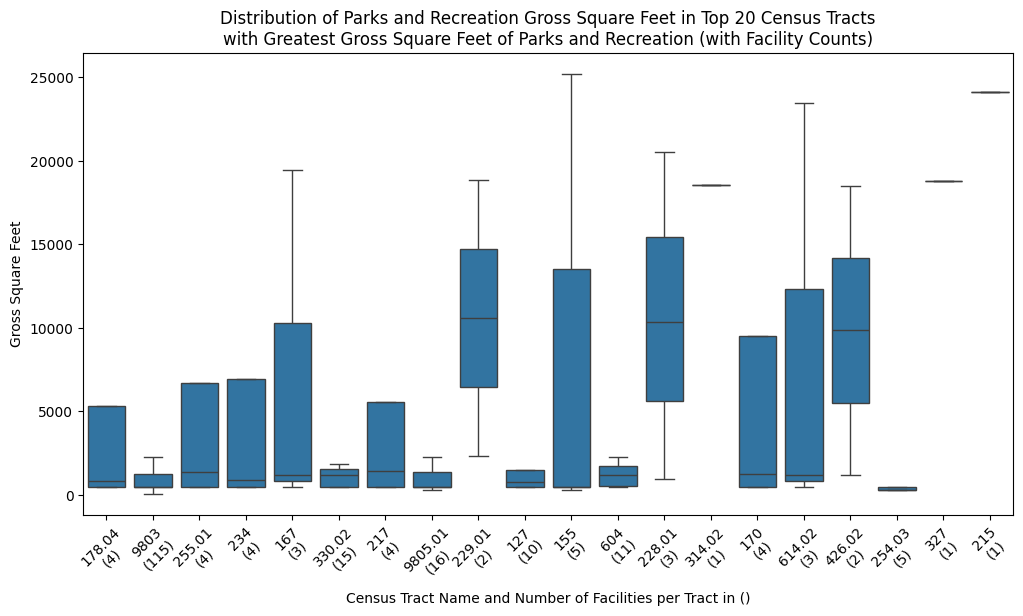

<Figure size 640x480 with 0 Axes>

In [81]:
# compute both total gross_sq_ft and facility counts per tract
tract_summary = (
    joined.groupby("NAME")
    .agg(total_sqft=("gross_sq_ft", "sum"), facility_count=("gross_sq_ft", "count"))
    .sort_values("total_sqft", ascending=False)
    .head(20)
    .reset_index()
)

# filter joined to top 20 tracts
top20_names = tract_summary["NAME"].tolist()
joined_top20 = joined[joined["NAME"].isin(top20_names)]

# create new label with tract name + facility count
tract_summary["label"] = tract_summary["NAME"] + "\n(" + tract_summary["facility_count"].astype(str) + ")"

# merge labels back to joined
joined_top20 = joined_top20.merge(tract_summary[["NAME", "label"]], on="NAME", how="left")

# plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=joined_top20,
    x="label",
    y="gross_sq_ft",
    showfliers=False
)
plt.xticks(rotation=45)
plt.title("Distribution of Parks and Recreation Gross Square Feet in Top 20 Census Tracts\nwith Greatest Gross Square Feet of Parks and Recreation (with Facility Counts)")
plt.xlabel("Census Tract Name and Number of Facilities per Tract in ()")
plt.ylabel("Gross Square Feet")
plt.show()

# save the plot in the visualizations folder
visualizations_dir = repo_root / 'visualizations'
visualizations_dir.mkdir(exist_ok=True)
plot_path = visualizations_dir / 'parks_rec_gross_sqft_boxplot_top20_tracts.png'
plt.savefig(plot_path)
